In [29]:
%matplotlib inline
import math
import collections
import random
import re
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

# 9.1. Working with Sequences

## 9.1.3. Training

1000 synthetic data will follow the trigonometric sin function, applied to 0.01 times the time step, and add addictive noise

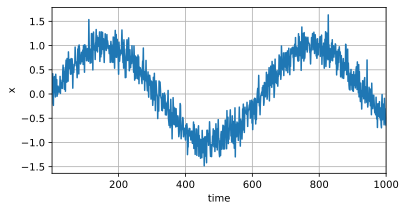

In [4]:
class Data(d2l.DataModule):
    def __init__(self, batch_size=16, T=1000, num_train=600, tau=4):
        self.save_hyperparameters()
        self.time = torch.arange(1, T + 1, dtype=torch.float32)
        self.x = torch.sin(0.01 * self.time) + torch.randn(T) * 0.2


data = Data()
d2l.plot(data.time, data.x, "time", "x", xlim=[1, 1000], figsize=(6, 3))

try a model that acts as if the data satisfied a k-order Markov condition, and thus predicts $x_t$ using only the past $\tau$ observations

In [5]:
@d2l.add_to_class(Data)
def get_dataloader(self, train):
    features = [self.x[i : self.T - self.tau + i] for i in range(self.tau)]
    self.features = torch.stack(features, 1)
    self.labels = self.x[self.tau :].reshape((-1, 1))
    i = slice(0, self.num_train) if train else slice(self.num_train, None)
    return self.get_tensorloader([self.features, self.labels], train, i)

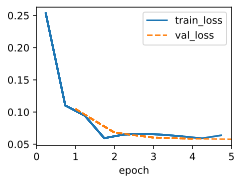

In [6]:
model = d2l.LinearRegression(lr=0.01)
trainer = d2l.Trainer(max_epochs=5)
trainer.fit(model, data)

## 9.1.4. Prediction

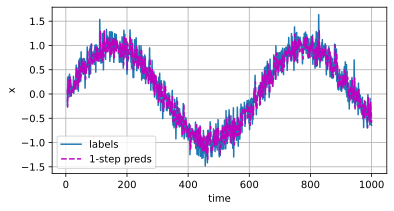

In [7]:
onestep_preds = model(data.features).detach().numpy()
d2l.plot(
    data.time[data.tau :],
    [data.labels, onestep_preds],
    "time",
    "x",
    legend=["labels", "1-step preds"],
    figsize=(6, 3),
)

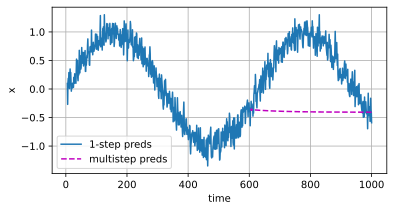

In [8]:
multistep_preds = torch.zeros(data.T)
multistep_preds[:] = data.x
for i in range(data.num_train + data.tau, data.T):
    multistep_preds[i] = model(multistep_preds[i - data.tau : i].reshape((1, -1)))
multistep_preds = multistep_preds.detach().numpy()

d2l.plot(
    [data.time[data.tau :], data.time[data.num_train + data.tau :]],
    [onestep_preds, multistep_preds[data.num_train + data.tau :]],
    "time",
    "x",
    legend=["1-step preds", "multistep preds"],
    figsize=(6, 3),
)

The predictions decay to a constant pretty quickly after a few steps because of errors can build up

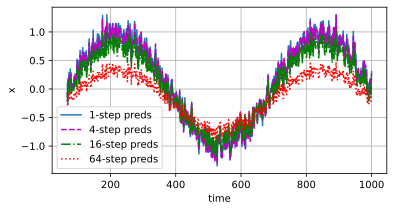

In [9]:
def k_step_pred(k):
    features = []
    for i in range(data.tau):
        features.append(data.x[i : i + data.T - data.tau - k + 1])
    # The (i+tau)-th element stores the (i+1)-step-ahead predictions
    for i in range(k):
        preds = model(torch.stack(features[i : i + data.tau], 1))
        features.append(preds.reshape(-1))
    return features[data.tau :]


steps = (1, 4, 16, 64)
preds = k_step_pred(steps[-1])
d2l.plot(
    data.time[data.tau + steps[-1] - 1 :],
    [preds[k - 1].detach().numpy() for k in steps],
    "time",
    "x",
    legend=[f"{k}-step preds" for k in steps],
    figsize=(6, 3),
)

# 9.2. Converting Raw Text into Sequence Data

## 9.2.1. Reading the Dataset

In [12]:
class TimeMachine(d2l.DataModule):  # @save
    """The Time Machine dataset."""

    def _download(self):
        fname = d2l.download(
            d2l.DATA_URL + "timemachine.txt",
            self.root,
            "090b5e7e70c295757f55df93cb0a180b9691891a",
        )
        with open(fname) as f:
            return f.read()


data = TimeMachine()
raw_text = data._download()
raw_text[:60]

'The Time Machine, by H. G. Wells [1898]\n\n\n\n\nI\n\n\nThe Time Tra'

ignore punctuation and capitalization when preprocessing the raw text

In [ ]:
@d2l.add_to_class(TimeMachine)  # @save
def _preprocess(self, text):
    return re.sub("[^A-Za-z]+", " ", text).lower()


text = data._preprocess(raw_text)
text[:60]

'the time machine by h g wells i the time traveller for so it'

## 9.2.2. Tokenization

In [15]:
@d2l.add_to_class(TimeMachine)  # @save
def _tokenize(self, text):
    return list(text)


tokens = data._tokenize(text)
",".join(tokens[:30])

't,h,e, ,t,i,m,e, ,m,a,c,h,i,n,e, ,b,y, ,h, ,g, ,w,e,l,l,s, '

## 9.2.3. Vocabulary

converting the sequence of strings into a list of numerical indices
- First, we determine the set of unique tokens in our training corpus
- We then assign a numerical index to each unique token. 
- Rare vocabulary elements are often dropped for convenience. 
- Whenever we encounter a token at training or test time that had not been previously seen or was dropped from the vocabulary, we represent it by a special “\<unk\>” token, signifying that this is an unknown value.

In [16]:
class Vocab:  # @save
    """Vocabulary for text."""

    def __init__(self, tokens=[], min_freq=0, reserved_tokens=[]):
        # Flatten a 2D list if needed
        if tokens and isinstance(tokens[0], list):
            tokens = [token for line in tokens for token in line]
        # Count token frequencies
        counter = collections.Counter(tokens)
        self.token_freqs = sorted(counter.items(), key=lambda x: x[1], reverse=True)
        # The list of unique tokens
        self.idx_to_token = list(
            sorted(
                set(
                    ["<unk>"]
                    + reserved_tokens
                    + [token for token, freq in self.token_freqs if freq >= min_freq]
                )
            )
        )
        self.token_to_idx = {token: idx for idx, token in enumerate(self.idx_to_token)}

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if hasattr(indices, "__len__") and len(indices) > 1:
            return [self.idx_to_token[int(index)] for index in indices]
        return self.idx_to_token[indices]

    @property
    def unk(self):  # Index for the unknown token
        return self.token_to_idx["<unk>"]

In [17]:
vocab = Vocab(tokens)
indices = vocab[tokens[:10]]
print("indices:", indices)
print("words:", vocab.to_tokens(indices))

indices: [21, 9, 6, 0, 21, 10, 14, 6, 0, 14]
words: ['t', 'h', 'e', ' ', 't', 'i', 'm', 'e', ' ', 'm']


## 9.2.4. Putting It All Together

returns 
- corpus, a list of token indices
- vocab, the vocabulary of The Time Machine corpus

In [18]:
@d2l.add_to_class(TimeMachine)  # @save
def build(self, raw_text, vocab=None):
    tokens = self._tokenize(self._preprocess(raw_text))
    if vocab is None:
        vocab = Vocab(tokens)
    corpus = [vocab[token] for token in tokens]
    return corpus, vocab


corpus, vocab = data.build(raw_text)
len(corpus), len(vocab)

(173428, 28)

## 9.2.5. Exploratory Language Statistics

In [19]:
words = text.split()
vocab = Vocab(words)
vocab.token_freqs[:10]

[('the', 2261),
 ('i', 1267),
 ('and', 1245),
 ('of', 1155),
 ('a', 816),
 ('to', 695),
 ('was', 552),
 ('in', 541),
 ('that', 443),
 ('my', 440)]

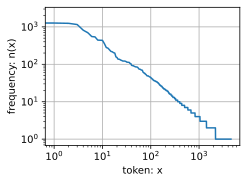

In [20]:
freqs = [freq for token, freq in vocab.token_freqs]
d2l.plot(freqs, xlabel="token: x", ylabel="frequency: n(x)", xscale="log", yscale="log")

Word frequency tends to follow a power law distribution (specifically the Zipfian) as we go down the ranks  
Zipf’s Law: 
$$\log n_i = -\alpha \log i + c,$$
where $\alpha$ is the exponent that characterizes the distribution and $c$ is a constant. 

In [21]:
bigram_tokens = ["--".join(pair) for pair in zip(words[:-1], words[1:])]
bigram_vocab = Vocab(bigram_tokens)
bigram_vocab.token_freqs[:10]

[('of--the', 309),
 ('in--the', 169),
 ('i--had', 130),
 ('i--was', 112),
 ('and--the', 109),
 ('the--time', 102),
 ('it--was', 99),
 ('to--the', 85),
 ('as--i', 78),
 ('of--a', 73)]

In [22]:
trigram_tokens = [
    "--".join(triple) for triple in zip(words[:-2], words[1:-1], words[2:])
]
trigram_vocab = Vocab(trigram_tokens)
trigram_vocab.token_freqs[:10]

[('the--time--traveller', 59),
 ('the--time--machine', 30),
 ('the--medical--man', 24),
 ('it--seemed--to', 16),
 ('it--was--a', 15),
 ('here--and--there', 15),
 ('seemed--to--me', 14),
 ('i--did--not', 14),
 ('i--saw--the', 13),
 ('i--began--to', 13)]

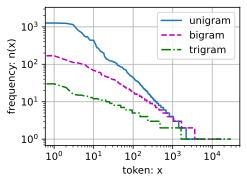

In [23]:
bigram_freqs = [freq for token, freq in bigram_vocab.token_freqs]
trigram_freqs = [freq for token, freq in trigram_vocab.token_freqs]
d2l.plot(
    [freqs, bigram_freqs, trigram_freqs],
    xlabel="token: x",
    ylabel="frequency: n(x)",
    xscale="log",
    yscale="log",
    legend=["unigram", "bigram", "trigram"],
)

- beyond unigram words, sequences of words also appear to be following Zipf’s law, albeit with a smaller exponent $\alpha$, depending on the sequence length
- the number of distinct n-grams is not that large
- many n-grams occur very rarely

# 9.3. Language Models

## 9.3.3. Partitioning Sequences

In [ ]:
@d2l.add_to_class(d2l.TimeMachine)  # @save
def __init__(self, batch_size, num_steps, num_train=10000, num_val=5000):
    """
    parameter:
        batch_size specifies the number of subsequence examples in each minibatch
        num_steps is the subsequence length in tokens."""
    super(d2l.TimeMachine, self).__init__()
    self.save_hyperparameters()
    corpus, self.vocab = self.build(self._download())
    array = torch.tensor(
        [corpus[i : i + num_steps + 1] for i in range(len(corpus) - num_steps)]
    )
    self.X, self.Y = array[:, :-1], array[:, 1:]

In [ ]:
@d2l.add_to_class(d2l.TimeMachine)  # @save
def get_dataloader(self, train):
    """randomly generates a minibatch from the dataset each time"""
    idx = (
        slice(0, self.num_train)
        if train
        else slice(self.num_train, self.num_train + self.num_val)
    )
    return self.get_tensorloader([self.X, self.Y], train, idx)

In [26]:
data = d2l.TimeMachine(batch_size=2, num_steps=10)
for X, Y in data.train_dataloader():
    print("X:", X, "\nY:", Y)
    break

X: tensor([[17,  0, 16, 19,  0,  2,  4,  4,  6, 13],
        [ 9,  2, 21,  0, 19,  2, 21,  9,  6, 19]]) 
Y: tensor([[ 0, 16, 19,  0,  2,  4,  4,  6, 13,  6],
        [ 2, 21,  0, 19,  2, 21,  9,  6, 19,  0]])


a minibatch of target sequences can be obtained by shifting the input sequences by one token

# 9.4. Recurrent Neural Networks

## 9.4.2. Recurrent Neural Networks with Hidden States

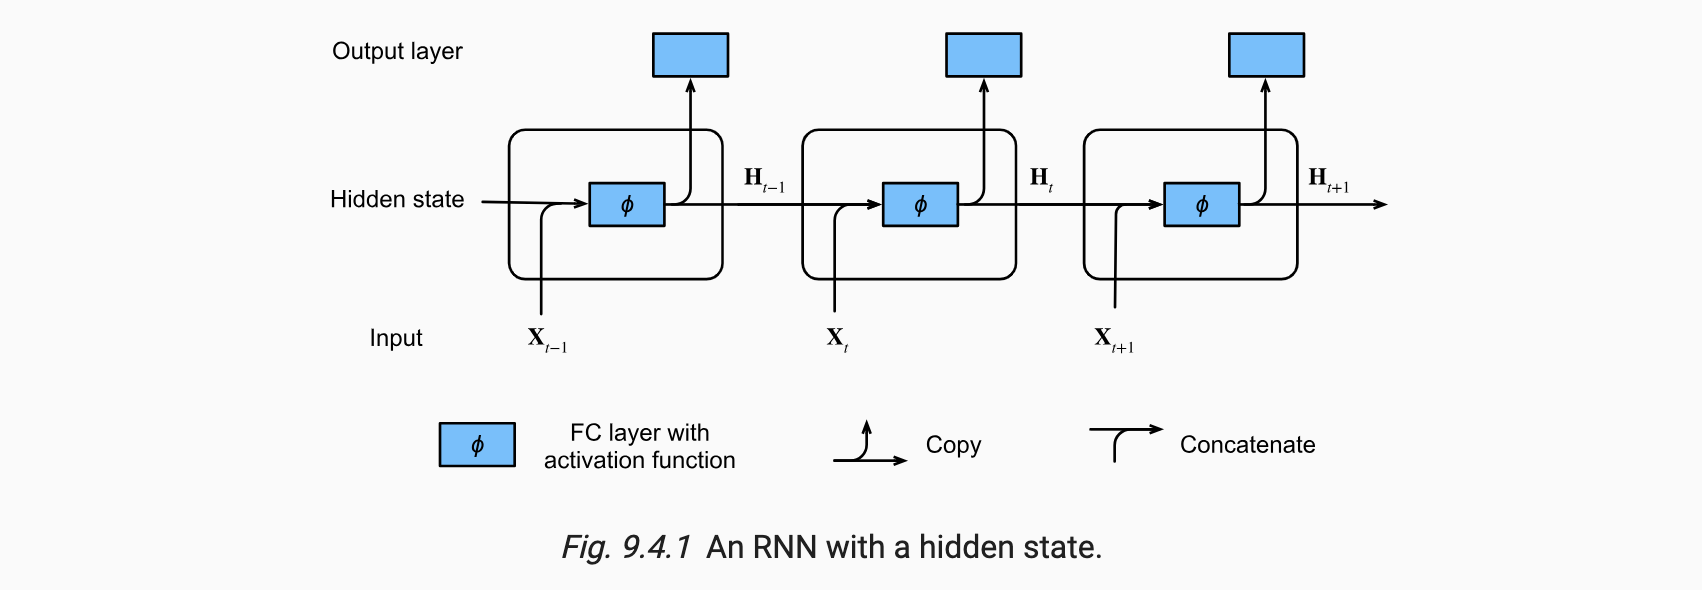

$$\mathbf{X}_t \mathbf{W}_{\textrm{xh}} + \mathbf{H}_{t-1} \mathbf{W}_{\textrm{hh}}$$

In [27]:
X, W_xh = torch.randn(3, 1), torch.randn(1, 4)
H, W_hh = torch.randn(3, 4), torch.randn(4, 4)
torch.matmul(X, W_xh) + torch.matmul(H, W_hh)

tensor([[-2.0593,  0.6771, -1.4862,  0.1801],
        [-2.7053, -1.1251,  3.0282, -2.4844],
        [-2.8729, -0.7550, -1.5135,  2.4058]])

concatenate the matrices X and H along columns (axis 1), and the matrices $W_{xh}$ and $W_{hh}$ along rows (axis 0). These two concatenations result in matrices of shape (3, 5) and of shape (5, 4), respectively. Multiplying these two concatenated matrices, we obtain the same output matrix of shape (3, 4) as above.

# 9.5. Recurrent Neural Network Implementation from Scratch

## 9.5.1. RNN Model

In [30]:
class RNNScratch(d2l.Module):  # @save
    """The RNN model implemented from scratch."""

    def __init__(self, num_inputs, num_hiddens, sigma=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.W_xh = nn.Parameter(torch.randn(num_inputs, num_hiddens) * sigma)
        self.W_hh = nn.Parameter(torch.randn(num_hiddens, num_hiddens) * sigma)
        self.b_h = nn.Parameter(torch.zeros(num_hiddens))

In [31]:
@d2l.add_to_class(RNNScratch)  # @save
def forward(self, inputs, state=None):
    if state is None:
        # Initial state with shape: (batch_size, num_hiddens)
        state = torch.zeros((inputs.shape[1], self.num_hiddens), device=inputs.device)
    else:
        (state,) = state
    outputs = []
    for X in inputs:  # Shape of inputs: (num_steps, batch_size, num_inputs)
        state = torch.tanh(
            torch.matmul(X, self.W_xh) + torch.matmul(state, self.W_hh) + self.b_h
        )
        outputs.append(state)
    return outputs, state

In [32]:
batch_size, num_inputs, num_hiddens, num_steps = 2, 16, 32, 100
rnn = RNNScratch(num_inputs, num_hiddens)
X = torch.ones((num_steps, batch_size, num_inputs))
outputs, state = rnn(X)

In [33]:
def check_len(a, n):  # @save
    """Check the length of a list."""
    assert len(a) == n, f"list's length {len(a)} != expected length {n}"


def check_shape(a, shape):  # @save
    """Check the shape of a tensor."""
    assert a.shape == shape, f"tensor's shape {a.shape} != expected shape {shape}"


check_len(outputs, num_steps)
check_shape(outputs[0], (batch_size, num_hiddens))
check_shape(state, (batch_size, num_hiddens))

## 9.5.2. RNN-Based Language Model

In [36]:
class RNNLMScratch(d2l.Classifier):  # @save
    """The RNN-based language model implemented from scratch."""

    def __init__(self, rnn, vocab_size, lr=0.01):
        super().__init__()
        self.save_hyperparameters()
        self.init_params()

    def init_params(self):
        self.W_hq = nn.Parameter(
            torch.randn(self.rnn.num_hiddens, self.vocab_size) * self.rnn.sigma
        )
        self.b_q = nn.Parameter(torch.zeros(self.vocab_size))

    def training_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot("ppl", torch.exp(l), train=True)
        return l

    def validation_step(self, batch):
        l = self.loss(self(*batch[:-1]), batch[-1])
        self.plot("ppl", torch.exp(l), train=False)

### 9.5.2.1. One-Hot Encoding

A one-hot encoding is a vector whose length is given by the size of the vocabulary $N$, where all entries are set to 0, except for the entry corresponding to our token, which is set to 1 

In [37]:
F.one_hot(torch.tensor([0, 2]), 5)

tensor([[1, 0, 0, 0, 0],
        [0, 0, 1, 0, 0]])

In [38]:
@d2l.add_to_class(RNNLMScratch)  # @save
def one_hot(self, X):
    # Output shape: (num_steps, batch_size, vocab_size)
    return F.one_hot(X.T, self.vocab_size).type(torch.float32)

### 9.5.2.2. Transforming RNN Outputs

In [39]:
@d2l.add_to_class(RNNLMScratch)  # @save
def output_layer(self, rnn_outputs):
    outputs = [torch.matmul(H, self.W_hq) + self.b_q for H in rnn_outputs]
    return torch.stack(outputs, 1)


@d2l.add_to_class(RNNLMScratch)  # @save
def forward(self, X, state=None):
    embs = self.one_hot(X)
    rnn_outputs, _ = self.rnn(embs, state)
    return self.output_layer(rnn_outputs)

In [40]:
model = RNNLMScratch(rnn, num_inputs)
outputs = model(torch.ones((batch_size, num_steps), dtype=torch.int64))
check_shape(outputs, (batch_size, num_steps, num_inputs))

## 9.5.3. Gradient Clipping

$$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g}\|}\right) \mathbf{g}$$
During training, gradient clipping can mitigate the problem of exploding gradients but does not address the problem of vanishing gradients

In [41]:
@d2l.add_to_class(d2l.Trainer)  # @save
def clip_gradients(self, grad_clip_val, model):
    params = [p for p in model.parameters() if p.requires_grad]
    norm = torch.sqrt(sum(torch.sum((p.grad**2)) for p in params))
    if norm > grad_clip_val:
        for param in params:
            param.grad[:] *= grad_clip_val / norm

## 9.5.4. Training

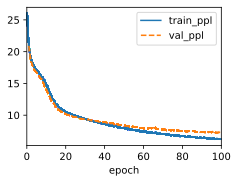

In [42]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNNScratch(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLMScratch(rnn, vocab_size=len(data.vocab), lr=1)
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

## 9.5.5. Decoding

Once a language model has been learned, we can use it not only to predict the next token but to continue predicting each subsequent one, treating the previously predicted token as though it were the next in the input.

In [43]:
@d2l.add_to_class(RNNLMScratch)  # @save
def predict(self, prefix, num_preds, vocab, device=None):
    state, outputs = None, [vocab[prefix[0]]]
    for i in range(len(prefix) + num_preds - 1):
        X = torch.tensor([[outputs[-1]]], device=device)
        embs = self.one_hot(X)
        rnn_outputs, state = self.rnn(embs, state)
        if i < len(prefix) - 1:  # Warm-up period
            outputs.append(vocab[prefix[i + 1]])
        else:  # Predict num_preds steps
            Y = self.output_layer(rnn_outputs)
            outputs.append(int(Y.argmax(axis=2).reshape(1)))
    return "".join([vocab.idx_to_token[i] for i in outputs])

In [44]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has and the thing the t'

# 9.6. Concise Implementation of Recurrent Neural Networks

## 9.6.1. Defining the Model

In [45]:
class RNN(d2l.Module):  # @save
    """The RNN model implemented with high-level APIs."""

    def __init__(self, num_inputs, num_hiddens):
        super().__init__()
        self.save_hyperparameters()
        self.rnn = nn.RNN(num_inputs, num_hiddens)

    def forward(self, inputs, H=None):
        return self.rnn(inputs, H)

In [46]:
class RNNLM(d2l.RNNLMScratch):  # @save
    """The RNN-based language model implemented with high-level APIs."""

    def init_params(self):
        self.linear = nn.LazyLinear(self.vocab_size)

    def output_layer(self, hiddens):
        return self.linear(hiddens).swapaxes(0, 1)

## 9.6.2. Training and Predicting

In [47]:
data = d2l.TimeMachine(batch_size=1024, num_steps=32)
rnn = RNN(num_inputs=len(data.vocab), num_hiddens=32)
model = RNNLM(rnn, vocab_size=len(data.vocab), lr=1)
model.predict("it has", 20, data.vocab)

'it hasxxxxxxxxxxxxxxxxxxxx'

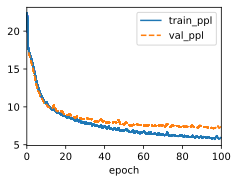

In [48]:
trainer = d2l.Trainer(max_epochs=100, gradient_clip_val=1, num_gpus=1)
trainer.fit(model, data)

In [49]:
model.predict("it has", 20, data.vocab, d2l.try_gpu())

'it has in the time tree so'